# K-Means GPU implementation

## Let's first define all the functions

In [1]:
import numpy as np
import math
import numba

from numba import cuda
from timeit import default_timer as timer


BLOCK_DIM = 128
K = 5

def k_means_plus_plus_initialization(data, k, BLOCK_DIM=BLOCK_DIM):
    """
    Initializes centers with k_means_plus_plus algorithm, to speed up convergence
    
    Parameters:
    data (2darray of shape (len(data), 2) ): the datapoints to be clustered ;

    k (int): the number of clusters ;

    BLOCK_DIM (int): dimension of a block (for gpu computing) ;
  
    Returns:
    centers (2darray of shape (k, 2)): 
    initialized coordinates of the cluster centers

    """
    @cuda.jit('void(float64[:, :], float64[:, :], float64[:])')
    def recompute_min_distances_to_centers(data, centers, min_distance_to_centers):
        """
        A kernel computes distances from each point to the centers selected 
        during the k_means++ algorithm
    
        Parameters:
        data (2darray of shape (len(data), 2) ): the datapoints to be clustered ;

        centers (2darray of shape (-1, 2) ): the selected centers ;

        min_distance_to_centers (1darray of size len(data) ):
        an array where minimal distances from points to centers will be stored ;
  
        Returns:
        None

        """
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        if i >= len(data):
            return
        min_d = 1e+10
        for c in centers:
            d = (data[i][0] - c[0]) ** 2 + (data[i][1] - c[1]) ** 2
            if d < min_d:
                min_d = d
        min_distance_to_centers[i] = min_d


    @cuda.jit('void(float64[:], float64[:], int64[:])')
    def reduce_max(min_distance_to_centers, max_values, max_indexs):
        """
        A kernel performs reduce algorithm to find the maximum values and their 
        indicies in the "min_distance_to_centers" array
    
        Parameters:
        min_distance_to_centers (1darray of size len(data) ) ;

        max_values (1darray of size ceil(len(data) / BLOCK_SIZE) ):
        an array where the maximum values will be stored ;

        max_indexs (1darray of size ceil(len(data) / BLOCK_SIZE) ):
        an array where the indexes of maximum values will be stored ;
  
        Returns:
        None

        """
        sdata = cuda.shared.array(shape=BLOCK_DIM, dtype=numba.float64)
        sindx = cuda.shared.array(shape=BLOCK_DIM, dtype=numba.int64)
        # load shared mem
        tid = cuda.threadIdx.x
        i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        if i >= len(min_distance_to_centers):
            sdata[tid] = 0.
        else:
            sdata[tid] = min_distance_to_centers[i]
        sindx[tid] = i
    
        cuda.syncthreads()
        # do reduction in shared mem
        s = cuda.blockDim.x // 2
        while s > 0:
            if (tid < s):
                if sdata[tid + s] > sdata[tid]:
                    sdata[tid] = sdata[tid + s]
                    sindx[tid] = sindx[tid + s]
            s = s // 2
        cuda.syncthreads()
        # write result for this block to global mem
        if tid == 0:
            max_values[cuda.blockIdx.x] = sdata[0]
            max_indexs[cuda.blockIdx.x] = sindx[0]

    data_d = cuda.to_device(data.astype(np.float64))
    centers = data[np.random.randint(len(data))].reshape((1, 2))
    min_distance_to_centers_d = cuda.to_device(np.zeros(len(data)).astype(np.float64))

    BLOCKS_PER_GRID = (len(data) - 1) // BLOCK_DIM + 1

    for i in range(k-1):
        centers_d = cuda.to_device(centers.astype(np.float64))
        recompute_min_distances_to_centers[BLOCKS_PER_GRID, BLOCK_DIM](data_d, centers_d, min_distance_to_centers_d)

        max_values_d = cuda.to_device(np.zeros(BLOCKS_PER_GRID).astype(np.float64))
        max_indexs_d = cuda.to_device(np.zeros(BLOCKS_PER_GRID).astype(np.int64))
        reduce_max[BLOCKS_PER_GRID, BLOCK_DIM](min_distance_to_centers_d, max_values_d, max_indexs_d)
        j = np.argmax(max_values_d.copy_to_host())
        idx = max_indexs_d.copy_to_host()[j]
        centers = np.concatenate((centers, data[idx].reshape(1, 2)), axis=0)

    return centers


@cuda.jit('void(float32[:, :], float32[:, :], float32[:], int32[:], float32[:, :, :], int16[:, :], int32)')
def update_step_gpu(data, centers_coordiantes, min_dists, min_indexes, 
                         out_coord, out_exsts, data_len):
    """
    The GPU-based update step of the K-Means algorithm.

    Parameters:
    data (2darray of shape (len(data), 2) ): the datapoints to be clustered ;

    centers_coordinates (2darray of shape (k, 2)): coordinates of cluster centers ;

    min_dists (1darray of size len(data)): 
    the array where minimal distances from points to centers ;

    min_indexes (1darray of size len(data)): 
    the array where indexes of corresponding cluster for each point are held ;

    out_coords (3darray of shape (BLOCKS_PER_GRID, k, 2)): array 
    where coordinates will be stored ;

    out_exsts (2darray of shape (BLOCKS_PER_GRID, k)): array 
    where the number of points in each cluster will be stored ;

    data_len (int): number of points for clustering ;

    k (int): number of clusters ;

    BLOCK_DIM (int): number of threads in block ;

    point_size (int): number of coords of a datapoint (2) .


    Returns:
    None
    """
    tid = cuda.threadIdx.x
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    coord = cuda.shared.array(shape=(BLOCK_DIM, K, 2), 
                              dtype=numba.float32)
    exsts = cuda.shared.array(shape=(BLOCK_DIM, K), dtype=numba.int16)

    for j in range(K):
        coord[tid][j][0] = 0.
        coord[tid][j][1] = 0.
        exsts[tid][j] = 0

    if i < data_len:
        min_d = 1e+9
        ind = 0
        point = data[i]

        for j, c in enumerate(centers_coordiantes):
            d = (point[0] - c[0]) ** 2 + (point[1] - c[1]) ** 2
            if d < min_d:
                min_d = d
                ind = j

        min_dists[i] = min_d
        min_indexes[i] = ind

        coord[tid][ind][0] = data[i][0]
        coord[tid][ind][1] = data[i][1]
        exsts[tid][ind] = 1

    cuda.syncthreads()
    
    s = cuda.blockDim.x // 2
    while s > 0:
        if (tid < s):
            for j in range(K):
                coord[tid][j][0] = coord[tid][j][0] + coord[tid + s][j][0]
                coord[tid][j][1] = coord[tid][j][1] + coord[tid + s][j][1]
                exsts[tid][j] = exsts[tid][j] + exsts[tid + s][j]
        s = s // 2
    cuda.syncthreads()
    # write result for this block to global mem
    if tid == 0:
        for j in range(K):
            out_coord[cuda.blockIdx.x][j][0] = coord[0][j][0]
            out_coord[cuda.blockIdx.x][j][1] = coord[0][j][1]
            out_exsts[cuda.blockIdx.x][j] = exsts[0][j]
 

def update_step_cpu(data, centers_coordiantes, min_dists, min_indexes, data_len):
    """
    See update_step_gpu, but without the use of GPU
    """
    for i in range(len(data)):
        for j, c in enumerate(centers_coordiantes):
            d = (data[i][0] - c[0]) ** 2 + (data[i][1] - c[1]) ** 2
            if d < min_dists[i]:
                min_dists[i] = d
                min_indexes[i] = j


def k_means_gpu(data, k=5, eps=1e-4, num_iter=300, BLOCK_DIM=BLOCK_DIM):
    """
    The K-Means algorithm itself, implemented with GPU

    Parameters:
    data (2darray of shape (len(data), 2) ): the datapoints to be clustered ;

    k (int): the number of clusters ;

    eps (float): Relative tolerance with regards to Frobenius norm 
    of the difference in the cluster centers of two consecutive iterations 
    to declare convergence ;

    num_iter (int): maximum number of iterations ;

    BLOCK_DIM (int): number of threads in a block

  
    Returns:
    (init_time, average_iter_time): times in seconds 
    of initialization and average iteration time

    centers_coordinates (2darray of shape (k, 2) ): coordinates of resulting
    centers

    min_indexes (1darray of size len(data)): cluster indexes of all the points 
    """
    # we first initialize centers:
    data_len = len(data)

    device = cuda.get_current_device()
    BLOCKS_PER_GRID = int(np.ceil((data_len) / BLOCK_DIM))

    start_init = timer()
    centers_coordinates = k_means_plus_plus_initialization(data, k, BLOCK_DIM)
    end_init = timer()
    init_time = end_init - start_init

    data_d = cuda.to_device(data.astype(np.float32))

    wall_time = 0

    for iter_ in range(num_iter):
    # for iter_ in tqdm(range(num_iter)):
        start_iter = timer()
        
        min_dists = (np.ones(len(data)) * 1e+10).astype(np.float32)
        min_indexes = np.zeros(len(data)).astype(int)

        centers_coordinates_d = cuda.to_device(centers_coordinates.astype(np.float32))

        min_dists_d = cuda.to_device(min_dists)
        min_indexes_d = cuda.to_device(min_indexes)
        old_centers_coordianates = np.copy(centers_coordinates)

        out_coord_d = cuda.to_device(np.zeros((BLOCKS_PER_GRID, k, 2)).astype(np.float32))
        out_exsts_d = cuda.to_device(np.zeros((BLOCKS_PER_GRID, k)).astype(np.int16))       

        t_uagpu_start = timer()
                         
        update_step_gpu[BLOCKS_PER_GRID, BLOCK_DIM](data_d, 
                centers_coordinates_d, min_dists_d, min_indexes_d, 
                out_coord_d, out_exsts_d, data_len)
        t_uagpu = timer() - t_uagpu_start
        
        min_indexes = min_indexes_d.copy_to_host()      

        t_cc_start = timer()
        out_coord = out_coord_d.copy_to_host().astype(np.float32)
        out_exsts = out_exsts_d.copy_to_host().astype(np.int32)
        centers_coordinates = np.sum(out_coord, axis=0) / np.sum(out_exsts, axis=0).reshape(-1, 1)
        t_cc = timer() - t_cc_start

        tol = np.linalg.norm(old_centers_coordianates - centers_coordinates)

        end_iter = timer()
        wall_time += (end_iter - start_iter)

        if tol < eps:
            return (init_time, wall_time / (iter_ + 1)), centers_coordinates, min_indexes

    return (init_time, wall_time / (iter_ + 1)), centers_coordinates, min_indexes


def recompute_centers(data, min_indexes, k):
    """
    Computes centers of the clusters.

    Parameters:
    data (2darray of shape (len(data), 2) ): the datapoints to be clustered ;

    min_indexes (1darray of size len(data)): 
    the array where indexes of corresponding cluster for each point are held ;

    k (int): number of clusters .


    Returns:
    centers_coordinates (2darray of shape (k, 2) ): coordinates of resulting
    centers
    """
    centers = np.zeros((k, data.shape[-1]))
    for i in range(k):
        mask = min_indexes == i
        sliced = data[mask]
        centers[i] = sliced.mean(axis=0)

    return centers


def k_means_plus_plus_initialization_cpu(data, k):
    """
    Initializes centers with k_means_plus_plus algorithm, 
    to speed up convergence (CPU)
    
    Parameters:
    data (2darray of shape (len(data), 2) ): the datapoints to be clustered ;

    k (int): the number of clusters ;
  
    Returns:
    centers (2darray of shape (k, 2)): 
    initialized coordinates of the cluster centers

    """
    centers = data[np.random.randint(len(data))].reshape((1, 2))
    min_distance_to_centers = np.zeros(len(data))

    for j in range(k-1):
        for i in range(len(data)):
            min_d = 1e+10
            for c in centers:
                d = (data[i][0] - c[0]) ** 2 + (data[i][1] - c[1]) ** 2
                if d < min_d:
                    min_d = d
            min_distance_to_centers[i] = min_d
        idx = np.argmax(min_distance_to_centers)
        centers = np.concatenate((centers, data[idx].reshape(1, 2)), axis=0)

    return centers


def k_means_cpu(data, k=5, eps=1e-4, num_iter=300):
    """
    The K-Means algorithm, naïve CPU implementation.

    Parameters:
    (init_time, average_iter_time): times in seconds 
    of initialization and average iteration time

    data (2darray of shape (len(data), 2) ): the datapoints to be clustered ;

    k (int): the number of clusters ;

    eps (float): Relative tolerance with regards to Frobenius norm 
    of the difference in the cluster centers of two consecutive iterations 
    to declare convergence ;

    num_iter (int): maximum number of iterations ;

 
    Returns:
    centers_coordinates (2darray of shape (k, 2) ): coordinates of resulting
    centers

    min_indexes (1darray of size len(data)): cluster indexes of all the points 
    """

    data_len = len(data)

    start_init = timer()
    centers_coordinates = k_means_plus_plus_initialization_cpu(data, k)
    end_init = timer()
    init_time = end_init - start_init

    wall_time = 0
    
    for iter_ in range(num_iter):
    # for iter_ in tqdm(range(num_iter)):
        start_iter = timer()

        min_dists = (np.ones(len(data)) * 1e+10).astype(np.float32)
        min_indexes = np.zeros(len(data)).astype(int)

        update_step_cpu(data, centers_coordinates, 
                                       min_dists, min_indexes, data_len)

        
        old_centers_coordianates = np.copy(centers_coordinates)
        centers_coordinates = recompute_centers(data, min_indexes, k)

        tol = np.linalg.norm(old_centers_coordianates - centers_coordinates)

        end_iter = timer()
        wall_time += (end_iter - start_iter)

        if tol < eps:
            return (init_time, wall_time / (iter_ + 1)), centers_coordinates, min_indexes

    return (init_time, wall_time / (iter_ + 1)), centers_coordinates, min_indexes

## Now, we define the data generating function

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

# takes time to initialize

center1 = (250, 700)
center2 = (800, 200)
center3 = (700, 900)
center4 = (350, 300)
center5 = (1000, 500)
centers = [center1, center2, center3, center4, center5]
distance = 3


def generate_data(points_in_clusters, centers=centers, distance=distance, plot=False):
    """
    Generates data.
    """
    xs = []
    ys = []
    for center in centers:
        xs.append(np.random.normal(center[0], distance, size=(points_in_clusters,)))
        ys.append(np.random.normal(center[1], distance, size=(points_in_clusters,)))

    if plot:
        for i in range(len(xs)):
            plt.scatter(xs[i], ys[i])
        plt.show()

    return np.concatenate([np.concatenate([x for x in xs])[None],
                           np.concatenate([y for y in ys])[None]], axis=0).T

## An example of data sample

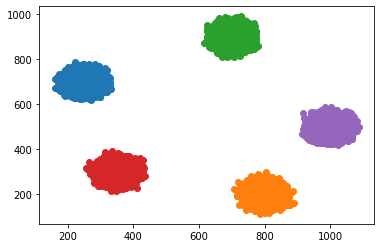

In [6]:
data = generate_data(int(cluster_size), distance=20, plot=True)

## Now, let's see how much time it takes for the algorithm to perform

In [3]:
def np_kmeans(data):
    res = KMeans(n_clusters=5, n_init=1, algorithm='full').fit(data)
    return (1, 1), res

n = 30

for f_name, f in {'gpu': k_means_gpu, ' np': np_kmeans, 'cpu': k_means_cpu}.items():
    for cluster_size in [1e+1, 1e+2, 1e+3, 1e+4, 1e+5, 1e+6, 1e+7]:
        init_times = 0
        iter_times = 0
        all_times = 0
        for i in range(n):
            data = generate_data(int(cluster_size))
            start = timer()
            init_time, iter_time = f(data)[0]
            end = timer()
            init_times += init_time
            iter_times += iter_time
            all_times += end - start
        print(f_name, 'cluster size', int(np.log10(cluster_size)), 'init_time', init_times / n, 'iter_time', iter_times / n, 'all_time', all_times / n)
    print()

gpu cluster size 1 init_time 0.4611504540334257 iter_time 0.0032355600667870023 all_time 0.4683297719334102
gpu cluster size 2 init_time 0.47275420136660007 iter_time 0.00330521703353952 all_time 0.48005458189982164
gpu cluster size 3 init_time 0.6269931337999879 iter_time 0.004669723449842423 all_time 0.6372034566334454
gpu cluster size 4 init_time 0.4760359978334842 iter_time 0.0039950596536498005 all_time 0.49745072073322566


KeyboardInterrupt: ignored